In [61]:
# db 접속 
# 우선 db 접속 후 원시 데이터 받기
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from config import DB_PASS
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# PostgreSQL 데이터베이스 연결 설정
username = 'psh0826'  # 사용자 이름
password = DB_PASS  # 비밀번호
host = 'localhost'  # 데이터베이스 서버 주소
port = '5432'  # 포트 번호
dbname = 'youtube_videos'  # 데이터베이스 이름
connection_string = f"postgresql://{username}:{password}@{host}:{port}/{dbname}"

# 데이터베이스 연결 엔진 생성
engine = create_engine(connection_string)

# SQL 쿼리 실행 및 데이터프레임으로 변환
query = "SELECT * FROM video_datas;"

# 데이터를 가져올 테이블명
df = pd.read_sql(query, engine)

# 데이터 확인
# info() 에서 수치형 / 문자열 등을 체크한다.
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2391 entries, 0 to 2390
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   video_id      2391 non-null   object        
 1   title         2391 non-null   object        
 2   time          2391 non-null   datetime64[ns]
 3   views         2391 non-null   int64         
 4   likes         2391 non-null   int64         
 5   dislikes      2391 non-null   int64         
 6   comments_cnt  2391 non-null   int64         
 7   comments      2391 non-null   object        
 8   query         2391 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 168.2+ KB
None


In [62]:

# 널값 확인
df.isnull()

# 널값 개수 확인
df.isnull().sum()
print(df.isna().sum())

# isna 는 시리얼 객체에도 적용됨.
df['video_id'].isna()
print(df['video_id'].isna().sum())


video_id        0
title           0
time            0
views           0
likes           0
dislikes        0
comments_cnt    0
comments        0
query           0
dtype: int64
0


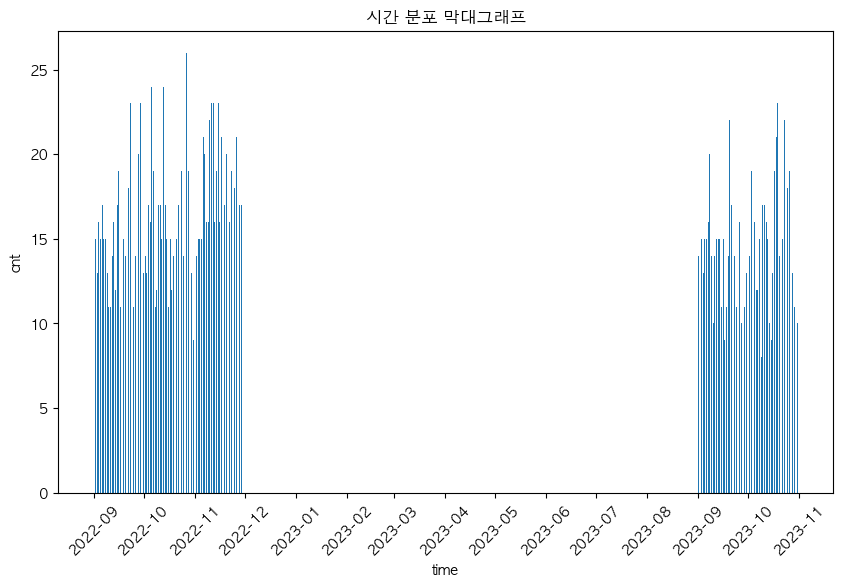

In [63]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 수치형 데이터 조사
df.describe()

# 수치형 데이터 중에서 이산형 데이터가 아니거나, 범위형이거나, 지금 처럼 시간이나 날짜 값인지 확인해본다.
# time 컬럼 데이터 확인
# print(df['time'])

# 정렬
# df['time'].dtypes
# print(pd.to_datetime(df['time'])) # 필요하면 날짜타입으로 바꾸고
# df['time'].sort_values()
# 이걸로 정렬이 안되면 밑에서 시리즈로 뽑아서 .sort_index()로 정렬해도 됨

# 시간대 시각화 

# 날짜를 시간까지만 나오게 하기
# 날짜까지만 분리해서 분포 조사
date_series = df['time'].dt.strftime('%Y-%m-%d')
# print(date_series)

# 시간대별로 데이터 개수 확인
time_series_cnt = date_series.value_counts().sort_index()
# print(time_series_cnt)

# 인덱스(날짜 문자열)를 datetime으로 변환
# 날짜형태로 바꿔줘야 밑에 x축 날짜형 포맷터가 작동함
time_series_cnt.index = pd.to_datetime(time_series_cnt.index)

# 막대 그래프
plt.figure(figsize=(10,6))
plt.bar(time_series_cnt.index, time_series_cnt.values, width = 0.5)

# x축 설정 (만약 막대 그래프를 더 뚱뚱하게 할려면 주별로 집계를 다시 하거나 해서 x축의 범위를 확 줄여야함)
plt.xticks(ticks=time_series_cnt.index, labels=time_series_cnt.index.strftime('%Y-%m'), rotation=45)

plt.xlabel('time')
plt.ylabel('cnt')
plt.title('시간 분포 막대그래프')

# x축 라벨 설정
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # 월별로 로케이터 설정
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # '년-월' 형식으로 포매터 설정

plt.show()

In [64]:
# 위 time 컬럼의 분포를 보면, 22년 9월 부터 11월, 23년 9월 부터 10월까지의 데이터임을 알수있다.
# 이는 처음부터 수집할때 가을 패션 트랜드를 알아보기 위함이었다.

# 일별로 수집된 비디오 개수를 보면, 
daily_counts = df['time'].dt.to_period('D').value_counts().sort_index()

# 일별 평균 계산
daily_avg = daily_counts.mean()
print('일 평균 비디오 개수: ', daily_avg)

# 일별 동영상은 평균 15개 정도 있었다. 

일 평균 비디오 개수:  15.730263157894736


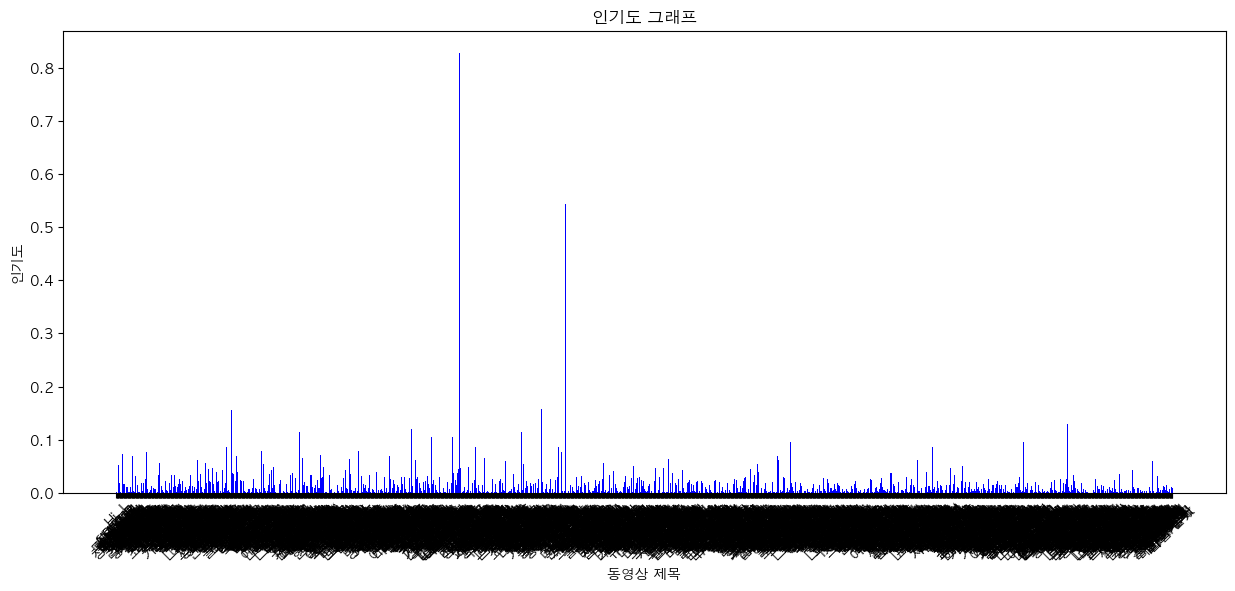

In [65]:
# 가장 인기 많은 동영상 알아보기
# 여기서 인기는 댓글수와 시청자수를 기준으로 한다.

# 좋아요와 댓글수 정규화
scaler = MinMaxScaler()
df['likes_normalized'] = scaler.fit_transform(df[['likes']])
df['comments_cnt_normalized'] = scaler.fit_transform(df[['comments_cnt']])

# 인기도 계산 (정규화된 좋아요와 댓글수의 평균)
df['popularity'] = df[['likes_normalized', 'comments_cnt_normalized']].mean(axis=1)

# 제목길이 조정
titles = df['title'].str[0:5]

# 막대 그래프 그리기
plt.figure(figsize=(15, 6))
plt.bar(titles, df['popularity'], color='blue')
plt.xlabel('동영상 제목')
plt.ylabel('인기도')
plt.title('인기도 그래프')
plt.xticks(rotation=45)

# 경고메시지 가리기 
import warnings
warnings.filterwarnings('ignore')

plt.show()

In [66]:
# 인기도 top 20 조사
# 인기도를 기준으로 데이터 정렬
top_videos = df.sort_values(by='popularity', ascending=False, ).head(20)

# 상위 100개 동영상의 타이틀 추출
top_titles = top_videos['title']


# 결과 출력
print(top_titles)

697                      몸에 스프레이를 뿌리자 10분 만에 완성된 드레스가 있다?
947                           진짜 부자들이 롤렉스 거르는 이유 (ft.메종철)
1238                😇수능이 끝나고 난 뒤 고3들의 모습ㅋㅋㅋㅋㅋㅋㅋㅋ
1093                                지금 사기엔 아깝 vs 지금 사도 괜츊
811                                 금수저 연대생 메종철의 천만원짜리 착장
293                     뉴진스 하입보이 커버 주우재 솔로 버전 세로캠 #shorts
616     ENG) [배배자매] 구독자 이벤트 | 올 가을 겨울 코디 준비 완료🍂❄️ 교복템 ...
2280                    굶주린 상태로 먹는 치킨과 고봉밥.. 이건 도저히 못참습니다
353                             개빡쳐서 초능력쓰게 된 우주하마 #Shorts
653     SUB) 뉴진스 민지? 여자아이돌 존예 멤버 커버룩 소개팅 (뉴진스, 아이브, 르세...
513                        님 옷을 왜 그렇게 입어요?;; 존나 과함;;; ㅠㅠㅠ
1057     NEW 최애쿠키 등극.. 먹어본 사람들 다 감동한 헤이즐넛가나슈샌드쿠키 with 위즈웰
1046                  70kg의 스키니 vs 와이드 뭐가 더 날씬할까? #shorts
215                                     셔츠 소매 예쁘게 접는 방법☝️
1994                                  소개팅에서 입지 말아야할 가을옷은?
405             68kg 통통녀의 난리나는 가을 데일리룩 (댓글 확인 필수) #shorts
617                                뉴진스 민지 연세대 축제 패션 알아보기!
2314          

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(-20.0, 0, '−20'),
  Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

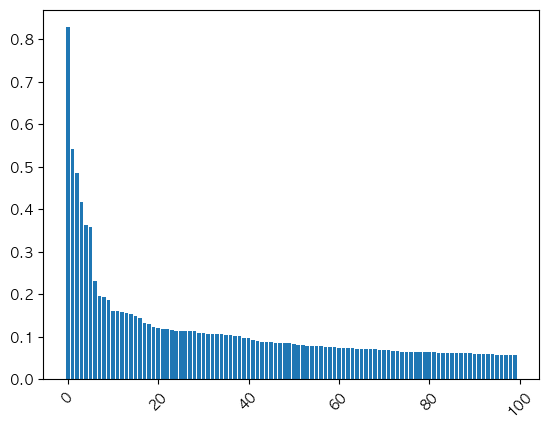

In [67]:

# 다시 top 100개 구하기
top_videos = df.nlargest(100, 'popularity')

#  nlargest 함수는 원래의 인덱스를 유지하기 때문에 이렇게 하면 100개로 정렬한 의미가 없어진다.
# titles_index = top_videos['title'].index


# x_pos 새로 인덱스 만들어서 주기
# 어차피 100개 니깐 그냥 이렇게 해도 된다.
x_pos = range(100)

# 다시 막대 그래프로 시각화
plt.bar(x_pos, top_videos['popularity'])
plt.xticks(rotation=45)

Text(0, 0.5, '인기도')

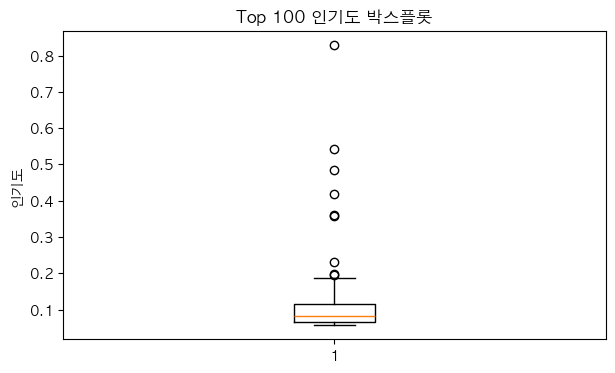

In [96]:
# 박스 플롯으로 분포도 조사
plt.figure(figsize=(7,4))
plt.boxplot(top_videos['popularity'])
plt.title('Top 100 인기도 박스플롯')
plt.ylabel('인기도')


In [69]:
# 박스 플롯의 수염을 (1분위수, 3분위수) 벗어난 인기도는 이상치로 간주하고 제거
Q1 = top_videos['popularity'].quantile(0.25)
Q3 = top_videos['popularity'].quantile(0.75)

IQR = Q3 - Q1

# 수염 범위
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

# 수염 범위 안에 있는 인기도로 필터링
filtered_videos = top_videos[(top_videos['popularity'] >= lower_bound) & (top_videos['popularity'] <= upper_bound)]

print(filtered_videos)



         video_id                                              title  \
653   CeVzbZBE-OA  SUB) 뉴진스 민지? 여자아이돌 존예 멤버 커버룩 소개팅 (뉴진스, 아이브, 르세...   
513   WxnDoSY0sU8                     님 옷을 왜 그렇게 입어요?;; 존나 과함;;; ㅠㅠㅠ   
1057  -NyOgI1zGI8   NEW 최애쿠키 등극.. 먹어본 사람들 다 감동한 헤이즐넛가나슈샌드쿠키 with 위즈웰   
1046  h9tZ6i2QLbQ                70kg의 스키니 vs 와이드 뭐가 더 날씬할까? #shorts   
215   DU4DQDDxnKA                                  셔츠 소매 예쁘게 접는 방법☝️   
...           ...                                                ...   
785   F9P37-iWphA             겨울옷 사기전에 보자! 겨울 가장 먼저 사야하는 옷들 [패션우선순위]   
43    pIf71qplZQc         가을에 이 "4가지"만 있으면 옷 걱정 끝!🍂가을 필수 스타일 [프론트로우]   
459   E4cYocTQtWA             남자라면 하나쯤 있어야할 “역대급” 니트 뽑았다 [콜라보왕EP.11]   
166   qW0isCiWsCc               제2의 전성기 📈 한동안 주춤했다가 최근 다시 떡상한 패션 아이템   
724   v_vfnqL-Xa4                                     이성이 가장 좋아하는 신발   

                    time    views  likes  dislikes  comments_cnt  \
653  2022-10-11 03:00:08  1178508  26341         0          1030   

In [70]:
# 이제 이상범위 안에 있는 영상들만 가지고 왜 이 영상들이 인기가 많았는지 제목을 분석해보자
'''
자연어 처리 이므로, 다음의 과정대로 진행한다.
1. 제목들 전처리 ( 한글만 남기고 다 제외, 공백도 띄어쓰기 한칸만 허용)
2. 토큰화 mecab()을 이용해서 한글어 형태소별로 토큰화를 한다. 
3. 불용어 설정 (제목들을 좀 보고 조금씩 추가 및 반복한다.)
4. 키워드 분석 (제목에서 자주 등장하는 중요 단어를 찾는다. 단어의 빈도수, tf-idf)
5. 4번을 토대로, 워드클라우드로 시각화 한다. 
'''


'\n자연어 처리 이므로, 다음의 과정대로 진행한다.\n1. 제목들 전처리 ( 한글만 남기고 다 제외, 공백도 띄어쓰기 한칸만 허용)\n2. 토큰화 mecab()을 이용해서 한글어 형태소별로 토큰화를 한다. \n3. 불용어 설정 (제목들을 좀 보고 조금씩 추가 및 반복한다.)\n4. 키워드 분석 (제목에서 자주 등장하는 중요 단어를 찾는다. 단어의 빈도수, tf-idf)\n5. 4번을 토대로, 워드클라우드로 시각화 한다. \n'

In [71]:
# 한국어 형태소 분석기 mecab 설치하기
'''
curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

pip install python-mecab-ko


'''
from mecab import MeCab

In [72]:
# 1. 제목 전처리
import re

def clean_text(text):
    text = re.sub("[^가-힣0-9]", " ", text)
    text = re.sub("\s+", " ", text)
    text.strip()

    return text

filtered_videos['cleand_title'] = filtered_videos['title'].apply(clean_text)
filtered_videos['cleand_title']


653      뉴진스 민지 여자아이돌 존예 멤버 커버룩 소개팅 뉴진스 아이브 르세라핌 에스파 닮...
513                                 님 옷을 왜 그렇게 입어요 존나 과함 
1057                최애쿠키 등극 먹어본 사람들 다 감동한 헤이즐넛가나슈샌드쿠키 위즈웰
1046                              70 의 스키니 와이드 뭐가 더 날씬할까 
215                                      셔츠 소매 예쁘게 접는 방법 
                              ...                        
785                  겨울옷 사기전에 보자 겨울 가장 먼저 사야하는 옷들 패션우선순위 
43                가을에 이 4가지 만 있으면 옷 걱정 끝 가을 필수 스타일 프론트로우 
459                     남자라면 하나쯤 있어야할 역대급 니트 뽑았다 콜라보왕 11 
166                    제2의 전성기 한동안 주춤했다가 최근 다시 떡상한 패션 아이템
724                                        이성이 가장 좋아하는 신발
Name: cleand_title, Length: 91, dtype: object

In [73]:
# 2. 토큰화
mecab = MeCab()

filtered_videos['tokenzied_title'] = filtered_videos['cleand_title'].apply(lambda x: mecab.morphs(x))
filtered_videos['tokenzied_title']

653     [뉴, 진스, 민지, 여자, 아이돌, 존, 예, 멤버, 커버, 룩, 소개팅, 뉴, ...
513                      [님, 옷, 을, 왜, 그렇게, 입, 어요, 존나, 과함]
1057    [최애, 쿠키, 등, 극, 먹, 어, 본, 사람, 들, 다, 감동, 한, 헤이즐넛,...
1046                   [70, 의, 스키니, 와이드, 뭐, 가, 더, 날씬, 할까]
215                             [셔츠, 소매, 예쁘, 게, 접, 는, 방법]
                              ...                        
785     [겨울옷, 사기전, 에, 보, 자, 겨울, 가장, 먼저, 사야, 하, 는, 옷, 들...
43      [가을, 에, 이, 4, 가지, 만, 있, 으면, 옷, 걱정, 끝, 가을, 필수, ...
459     [남자, 라면, 하나, 쯤, 있, 어야, 할, 역대, 급, 니트, 뽑, 았, 다, ...
166     [제, 2, 의, 전성기, 한동안, 주춤, 했, 다가, 최근, 다시, 떡, 상한, ...
724                           [이성, 이, 가장, 좋, 아, 하, 는, 신발]
Name: tokenzied_title, Length: 91, dtype: object

In [99]:
# 3. 불용어 제거
# 불용어 리스트 import
# from stopwords import stopwords
stopwords = [
    '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다',
    '그', '있', '되', '이런', '있는', '여러', '너무', '다시', '이렇게', '그리고', '이것', '것은', '있습니다', '여기', 
    '이번', '이렇', '합니다', '어떤', '지금', '위해'
]
additional_stopwords = ['비', '어', '더', '어야', '할', '어요', '로', '게', '았', '다', '하', '계', '기', '을', '아', '입','옷', '룩', '꼭', '으면', '탕', '가', '녀','있', '예쁘', '닮','팅','한', '알아보', '뽑']
stopwords.extend(additional_stopwords)

filtered_videos['tokens_without_stopwords'] = filtered_videos['tokenzied_title'].apply(
    lambda x: [token for token in x if token not in stopwords]
)

filtered_videos['tokens_without_stopwords']

653     [뉴, 진스, 민지, 여자, 아이돌, 존, 예, 멤버, 커버, 소개팅, 뉴, 진스,...
513                                   [님, 왜, 그렇게, 존나, 과함]
1057    [최애, 쿠키, 등, 극, 먹, 본, 사람, 감동, 헤이즐넛, 나, 슈, 샌드, 쿠...
1046                            [70, 스키니, 와이드, 뭐, 날씬, 할까]
215                                       [셔츠, 소매, 접, 방법]
                              ...                        
785             [겨울옷, 사기전, 보, 겨울, 가장, 먼저, 사야, 패션, 우선, 순위]
43          [가을, 4, 가지, 만, 걱정, 끝, 가을, 필수, 스타, 일, 프론, 트로우]
459                [남자, 라면, 하나, 쯤, 역대, 급, 니트, 콜라보, 왕, 11]
166       [제, 2, 전성기, 한동안, 주춤, 했, 다가, 최근, 떡, 상한, 패션, 아이템]
724                                       [이성, 가장, 좋, 신발]
Name: tokens_without_stopwords, Length: 91, dtype: object

In [100]:
# 4. 키워드 분석
from collections import Counter

# 토큰을 모두 통합 2중 리스트를 하나로 통합하기에는 sum(2중리스트,[]) 이게 편하다.
all_tokens = sum(filtered_videos['tokens_without_stopwords'].tolist(), [])

# 빈도수 
token_counts = Counter(all_tokens)

# 빈도수 top 100위
print(token_counts.most_common(100))

[('패션', 20), ('가을', 12), ('남자', 12), ('겨울', 11), ('콜라보', 10), ('코디', 10), ('브랜드', 9), ('만', 9), ('왕', 8), ('법', 8), ('템', 8), ('패딩', 8), ('역대', 7), ('급', 7), ('코트', 7), ('가지', 7), ('추천', 7), ('10', 6), ('요즘', 6), ('스타일', 6), ('대', 6), ('뉴', 5), ('진스', 5), ('개', 5), ('나', 5), ('라면', 5), ('했', 5), ('까지', 5), ('공항', 5), ('가격', 5), ('방법', 4), ('통통', 4), ('필수', 4), ('가장', 4), ('고', 4), ('니트', 4), ('기본', 4), ('원', 4), ('보이', 4), ('갓', 4), ('좋', 4), ('루', 4), ('여자', 3), ('르', 3), ('에스파', 3), ('사람', 3), ('슈', 3), ('뭐', 3), ('68', 3), ('데일리', 3), ('하나', 3), ('셋', 3), ('업', 3), ('만들', 3), ('엔', 3), ('연출', 3), ('인', 3), ('스타', 3), ('스트릿', 3), ('일', 3), ('겨울옷', 3), ('가성', 3), ('5', 3), ('4', 3), ('가죽', 3), ('백', 3), ('12', 3), ('성비', 3), ('유행', 3), ('년', 3), ('싶', 3), ('후', 3), ('보', 3), ('북', 3), ('민지', 2), ('소개팅', 2), ('쿠키', 2), ('등', 2), ('극', 2), ('먹', 2), ('에서', 2), ('지', 2), ('아야', 2), ('아우', 2), ('터', 2), ('디자인', 2), ('던', 2), ('면', 2), ('먼저', 2), ('갑자기', 2), ('쯤', 2), ('었', 2), ('그램', 2), 

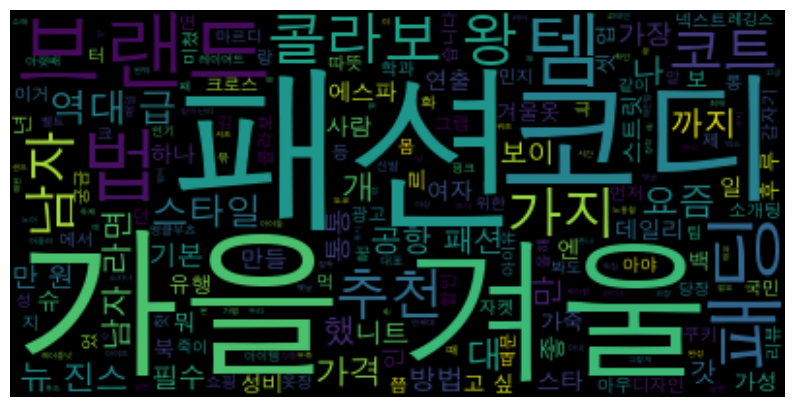

In [101]:
# 5. 시각화
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 워드 클라우드 생성
wordcloud = WordCloud(font_path='/Library/Fonts/AppleGothic.ttf').generate(' '.join(all_tokens))

# 워드 클라우드 시각화
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 인기도가 높은 영상들의 제목들을 분석한 결과 다음과 같은 단어들이 자주 등장한다.

In [ ]:
# 다음은 영상의 시간대에 따라서 인기도의 변화를 알아보자
